In [1]:
##################### Inpainting Stable Diffusion from JumpStart model
## Detailed instructions here
## https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/jumpstart_inpainting/Amazon_JumpStart_Inpainting.ipynb
##
##
## Step 1 - initial configuration
## Step 2 - Start Sagemaker inference endpoint
## Step 3 - create request to test endpoint
## Step 4 - Test endpoint work with boto3
## Step 5 - clean up Sagemaker endpoints to avoid unexpected charges
##
##

In [6]:
## Step 1 - initial configuration
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

model_id, model_version = "model-inpainting-stabilityai-stable-diffusion-2-inpainting-fp16", "*"
# Hardcode endpoint name to simplify demo start
endpoint_name = "jumpstart-example-model-inpainting-demo-on-miro-1"

from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

# Instances with more GPU memory supports generation of larger images.
# So, please select instance types such as ml.g5.2xlarge if you want to generate a very large image.
inference_instance_type = "ml.p3.2xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the model uri. This includes the pre-trained model and parameters as well as the inference scripts.
# This includes all dependencies and scripts for model loading, inference handling etc..
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)


In [16]:
%%time
## Step 2 -Start Sagemaker inference endpoint

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

print ("Endpoint name: ", model_predictor.endpoint_name)

----------!CPU times: user 220 ms, sys: 29.3 ms, total: 249 ms
Wall time: 5min 33s


In [9]:
################################################
##
## Step 3: create request to test endpoint
##
## Create test images
##
#################################################
from PIL import Image, ImageDraw
import requests, base64, io

# Test image
image_url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"

image = Image.open(requests.get(image_url, stream=True).raw)

b = io.BytesIO()
image.save(b, 'jpeg')
encoded_input_image = base64.b64encode(bytearray(b.getvalue())).decode()
    
# create test mask
mask_image = Image.new(mode="L", size=image.size)

draw = ImageDraw.Draw(mask_image)
draw.ellipse((150, 0, 350, 200), fill=(255), outline=(0))

b_m = io.BytesIO()
mask_image.save(b_m, 'jpeg')
encoded_mask_image = base64.b64encode(bytearray(b_m.getvalue())).decode()


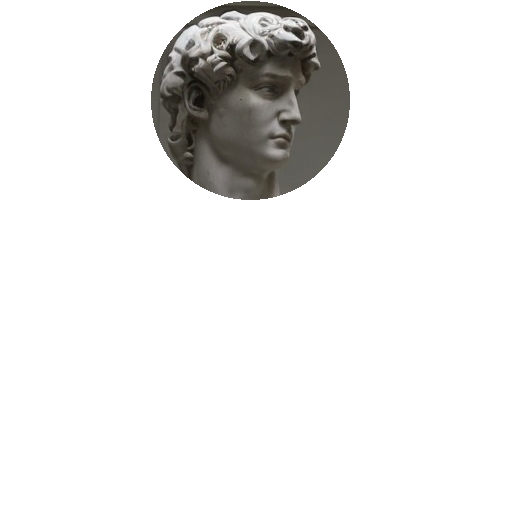

In [10]:
# Test mask image

im2 = Image.new(mode="RGB", size =image.size, color = 'white')
im = Image.composite(image, im2, mask_image)
im

In [14]:
parameters = {
    "action" : "inpaint",
    "prompt": "turn statue into a white cat, blue eyes, wearing a sweater",
    "image": encoded_input_image,
    "mask_image" : encoded_mask_image,
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
    "seed": 0,
    "negative_prompt": "poorly drawn face",
}


In [12]:
%%time
#### Step 4 - Test endpoint work with boto3

######################################################
# Check endpoint proper work through boto3 call      #
######################################################
# Create image from result
from io import BytesIO
import base64
from PIL import Image
import json

runtime = boto3.client('runtime.sagemaker')

request_parameters = {}
#parameters = json.loads(parameters)
# transfer to request_parameters only valid fields
for i in ['prompt', 'negative_prompt', 'seed', 'image', 'mask_image']:
    if i in parameters:
        request_parameters[i] = parameters[i]

encoded_text = json.dumps(request_parameters).encode("utf-8")
print ("Call endpoint: ", endpoint_name )
#print ("With parameters: ", encoded_text)

response = runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType='application/json;jpeg',
                                   Body=encoded_text)
print ("Received reply from endpoint, len: ", len(response))
response_image = response["Body"]
stream = response_image.read()
data = json.loads(stream)

import numpy as np
responce_array = data['generated_images'][0]
# create Image from stream
new_image = Image.fromarray(np.array(responce_array).astype('uint8'), 'RGB')


Call endpoint:  jumpstart-example-model-inpainting-stab-2023-05-14-20-09-34-589
Received reply from endpoint, len:  4
CPU times: user 571 ms, sys: 19.6 ms, total: 590 ms
Wall time: 4.73 s


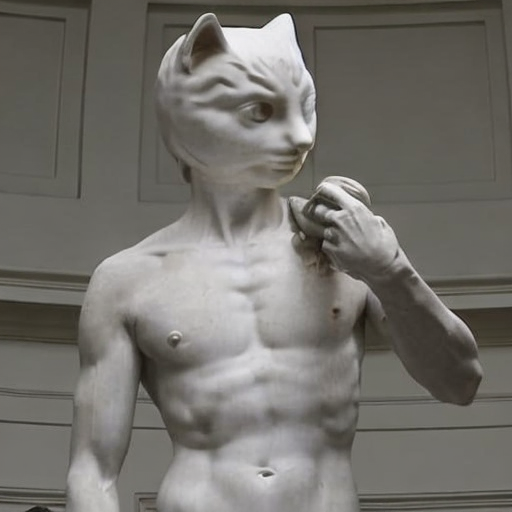

In [13]:
new_image

aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1666878620108/work
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
alabaster==0.7.12
aniso8601==9.0.1
ansi2html==1.8.0
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1666191106763/work/dist
appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1666850859330/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1662382474514/work
astroid @ file:///home/conda/feedstock_root/build_artifacts/astroid_1655142261672/work
astropy @ file:///home/conda/feedstock_root/build_artifacts/astropy_1670876536455/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1670263926556/work
async-timeout @ file:///home/conda/feed

In [16]:
#### After successful demo, please don't forget to clean up the endpoints to avoid unexpected charges ###############################
##  Step 5 - clean up
predictor = sagemaker.predictor.Predictor(endpoint_name)
predictor.delete_model()
predictor.delete_endpoint()